# Homework 3

## Course Name: Deep Learning
#### Lecturer: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Rahimi, Zahra Khoramnejad, Mehran Sarmadi

**Contact**: Ask your questions in Quera

---

**Note**: Replace the placeholders (between `## COMPLETE THE FOLLOWING SECTION  ##` and `## THE END ##`) with the appropriate details.


---
---
## 1 Introduction

In this notebook you have to design and train models for a time series prediction task on the provided dataset using these three different architectures:

- Simple RNN

- GRU

- LSTM

You will compare and rank them at the end of the notebook and explain why they were ranked that way.

---
### 1.1 Imports

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import copy

---
---
## 2 Dataset
Electric Production IP Dataset

In [2]:
df = pd.read_csv('Electric_Production.csv', index_col='Date', parse_dates=True, dtype=np.float32)

In [3]:
df.head()

,Value
Date,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float32
dtypes: float32(1)
memory usage: 4.7 KB


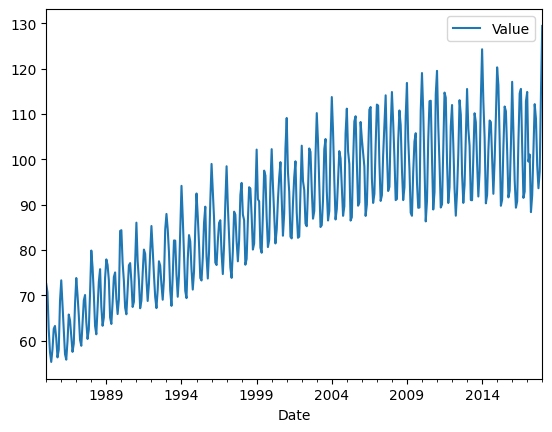

In [5]:
df.plot();

---
### 2.1 Load and prepare Dataset

In [6]:
def prepare_dataset(dataset, look_back):
    """Transform a time series data into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        look_back: Size of window for prediction
    """
    X, y = [], []
    dataset = np.array(dataset)
    data_length = len(dataset)
    for i in range(look_back, data_length):
        input = dataset[i-look_back: i]
        output = dataset[i]
        X.append(input)
        y.append(output)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
look_back = 60

data_length = len(df)

train_data_size = int(data_length * 0.75)
validaion_data_size = int(data_length * 0.25)


train_data = df[: train_data_size]
validation_data = df[train_data_size: ]


X_train, y_train = prepare_dataset(train_data, look_back)
X_val, y_val = prepare_dataset(validation_data, look_back)


X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)


print(  f"Shape of X_train data -> {X_train.shape} \n"
        f"Shape of y_train data -> {y_train.shape} \n"
        f"Shape of X_val data -> {X_val.shape} \n"
        f"Shape of y_val data -> {y_val.shape} \n"
    )


Shape of X_train data -> torch.Size([237, 60, 1]) 
Shape of y_train data -> torch.Size([237, 1]) 
Shape of X_val data -> torch.Size([40, 60, 1]) 
Shape of y_val data -> torch.Size([40, 1]) 



---
---
## 3 Trainer function

In [9]:
def trainer(model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs):
    early_stopping_patience = 150
    early_stopping_counter = 0

    valid_loss_min=np.inf
    best_model = copy.deepcopy(model)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        # Forward and loss
        predictions  = model(X_train)
        train_loss = criterion(predictions.view(-1), y_train.view(-1))
        train_losses.append(train_loss.item())
        # Backward and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            output_val = model(X_val)
            valid_loss = criterion(output_val, y_val)
            val_losses.append(valid_loss.item())

            if valid_loss <= valid_loss_min:
                best_model = best_model = copy.deepcopy(model)
                print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).')
                valid_loss_min = valid_loss
                early_stopping_counter = 0    # Reset counter if validation loss decreases
            else:
                print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
                early_stopping_counter += 1

            if early_stopping_counter > early_stopping_patience:
                print('Early stopped at epoch :', epoch)
                break

            print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

    return best_model, train_losses, val_losses

---
---
## 4 RNN

---
### 4.1 Define single RNN cell

In [10]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size, bias=bias)
        self.Whh = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.bias = bias
        self.bias_Wxh = nn.Parameter(torch.Tensor(hidden_size)) if bias else self.register_parameter('bias_Wxh', None)
        self.bias_Whh = nn.Parameter(torch.Tensor(hidden_size)) if bias else self.register_parameter('bias_Whh', None)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        if self.bias:
          hy = torch.tanh(self.Wxh(input) + self.Whh(hx) + self.bias_Wxh + self.bias_Whh)
        else:
          hy = torch.tanh(self.Wxh(input) + self.Whh(hx))
        return hy

---
### 4.2 RNN model

In [11]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list.append(RNNCell(input_size, hidden_size, bias))
        self.bias = bias
        for l in range(1, num_layers):
            self.rnn_cell_list.append(RNNCell(hidden_size, hidden_size, bias))
        self.fc = nn.Linear(hidden_size, output_size, bias=bias)

    def forward(self, input, hx=None):
        outs = []
        h0 = [None] * len(self.rnn_cell_list) if hx is None else list(hx)
        X = list(input.permute(1, 0, 2))
        for j, cell in enumerate(self.rnn_cell_list):
            hx_minus_one = h0[j]
            for i in range(input.shape[1]):
                hx = cell(X[i], hx_minus_one)
                hx_minus_one = hx
                X[i] = hx
            outs.append(hx)
        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

---
### 4.3 Train RNN model and plot losses

In [12]:
# Instantiate model
SimpleRNN_model = SimpleRNN(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
SimpleRNN_model.to(device)

SimpleRNN(
  (rnn_cell_list): ModuleList(
    (0): RNNCell(
      (Wxh): Linear(in_features=1, out_features=50, bias=True)
      (Whh): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [13]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SimpleRNN_model.parameters(), lr = learning_rate)

In [14]:
SimpleRNN_best_model, train_losses, val_losses = trainer(SimpleRNN_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
	 Train_Loss: 195.5847 Val_Loss: 578.4521  BEST VAL Loss: 578.4521

Epoch 334: Validation loss decreased (578.452087 --> 575.035095).
	 Train_Loss: 194.3929 Val_Loss: 575.0351  BEST VAL Loss: 575.0351

Epoch 335: Validation loss decreased (575.035095 --> 571.658081).
	 Train_Loss: 193.2238 Val_Loss: 571.6581  BEST VAL Loss: 571.6581

Epoch 336: Validation loss decreased (571.658081 --> 568.323181).
	 Train_Loss: 192.0768 Val_Loss: 568.3232  BEST VAL Loss: 568.3232

Epoch 337: Validation loss decreased (568.323181 --> 565.029297).
	 Train_Loss: 190.9518 Val_Loss: 565.0293  BEST VAL Loss: 565.0293

Epoch 338: Validation loss decreased (565.029297 --> 561.775330).
	 Train_Loss: 189.8482 Val_Loss: 561.7753  BEST VAL Loss: 561.7753

Epoch 339: Validation loss decreased (561.775330 --> 558.560730).
	 Train_Loss: 188.7658 Val_Loss: 558.5607  BEST VAL Loss: 558.5607

Epoch 340: Validation loss decreased (558.560730 --> 555.385376).
	 Train_Los

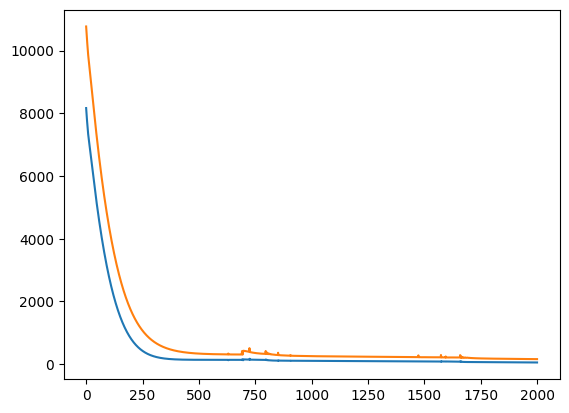

In [15]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 4.4 Evaluate model on validation data

In [16]:
val_predict_RNN = SimpleRNN_best_model(X_val)

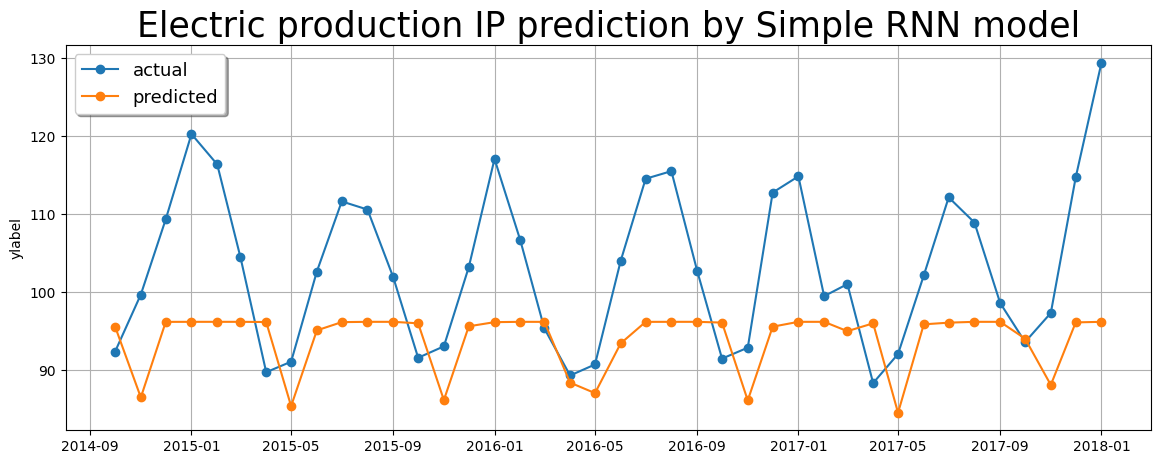

In [17]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by Simple RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 5 GRU

---
### 5.1 Define single GRU cell

In [18]:
class GRUCell(torch.nn.Module):
    """
    A simple GRU cell network for educational purposes
    """

    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.bias = bias

        """Define Needed Layers """
        self.reset_gate_Wxh = torch.nn.Linear(input_length, hidden_size, bias=bias)
        self.reset_gate_Whh = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        self.update_gate_Wxh = torch.nn.Linear(input_length, hidden_size, bias=bias)
        self.update_gate_Whh = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        self.output_gate_Wxh = torch.nn.Linear(input_length, hidden_size, bias=bias)
        self.output_gate_Whh = torch.nn.Linear(hidden_size, hidden_size, bias=bias)

        bias_params = [nn.Parameter(torch.Tensor(hidden_size)) if self.bias else 0 for _ in range(3)]
        self.br, self.bu, self.bo = bias_params


        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def reset_gate(self, x, h):
        return torch.sigmoid(self.reset_gate_Wxh(x) + self.reset_gate_Whh(h) + self.br)


    def update_gate(self, x, h):
        return torch.sigmoid(self.update_gate_Wxh(x) + self.update_gate_Whh(h) + self.bu)


    def output_gate(self, x,h,r):
        return torch.tanh(self.output_gate_Wxh(x) + r * self.output_gate_Whh(h) + self.bo)


    def forward(self, x, h):
        """Define Forward pass"""
        if h is None:
          h = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        r = self.reset_gate(x, h)
        z = self.update_gate(x, h)
        n_t = self.output_gate(x, h, r)
        h_new = (1 - z) * n_t + z * h

        return h_new


---
### 5.2 GRU model

In [19]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru_cells = nn.ModuleList([GRUCell(input_size if layer == 0 else hidden_size,
                                              hidden_size, bias) for layer in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = [torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device) for _ in range(self.num_layers)]

        output = []
        for t in range(input.size(1)):
            next_input = input[:,t]
            for layer, gru_cell in enumerate(self.gru_cells):
                hx[layer] = gru_cell(next_input, hx[layer])
                next_input = hx[layer]

            output.append(hx[-1])

        output = torch.stack(output)
        output = self.fc(output[-1])

        return output

---
### 5.3 Train GRU model and plot losses

In [20]:
GRU_model = GRU(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
GRU_model.to(device)

GRU(
  (gru_cells): ModuleList(
    (0): GRUCell(
      (reset_gate_Wxh): Linear(in_features=1, out_features=50, bias=True)
      (reset_gate_Whh): Linear(in_features=50, out_features=50, bias=True)
      (update_gate_Wxh): Linear(in_features=1, out_features=50, bias=True)
      (update_gate_Whh): Linear(in_features=50, out_features=50, bias=True)
      (output_gate_Wxh): Linear(in_features=1, out_features=50, bias=True)
      (output_gate_Whh): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [21]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr = learning_rate)

In [22]:
GRU_best_model, train_losses, val_losses = trainer(GRU_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
	 Train_Loss: 201.1709 Val_Loss: 594.1055  BEST VAL Loss: 594.1055

Epoch 334: Validation loss decreased (594.105530 --> 590.431824).
	 Train_Loss: 199.8498 Val_Loss: 590.4318  BEST VAL Loss: 590.4318

Epoch 335: Validation loss decreased (590.431824 --> 586.803406).
	 Train_Loss: 198.5544 Val_Loss: 586.8034  BEST VAL Loss: 586.8034

Epoch 336: Validation loss decreased (586.803406 --> 583.220337).
	 Train_Loss: 197.2838 Val_Loss: 583.2203  BEST VAL Loss: 583.2203

Epoch 337: Validation loss decreased (583.220337 --> 579.682129).
	 Train_Loss: 196.0378 Val_Loss: 579.6821  BEST VAL Loss: 579.6821

Epoch 338: Validation loss decreased (579.682129 --> 576.188660).
	 Train_Loss: 194.8161 Val_Loss: 576.1887  BEST VAL Loss: 576.1887

Epoch 339: Validation loss decreased (576.188660 --> 572.738770).
	 Train_Loss: 193.6180 Val_Loss: 572.7388  BEST VAL Loss: 572.7388

Epoch 340: Validation loss decreased (572.738770 --> 569.332153).
	 Train_Los

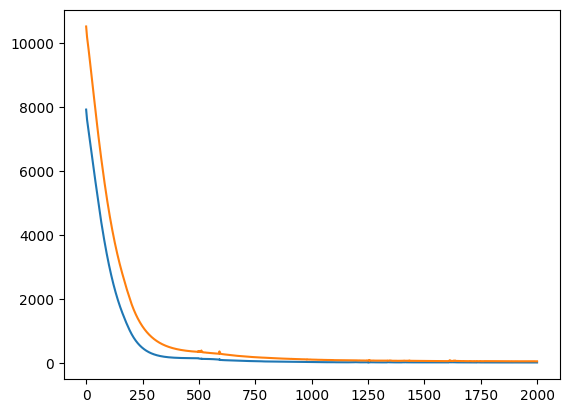

In [23]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 5.4 Evaluate model on validation data

In [24]:
val_predict_GRU = GRU_best_model(X_val)

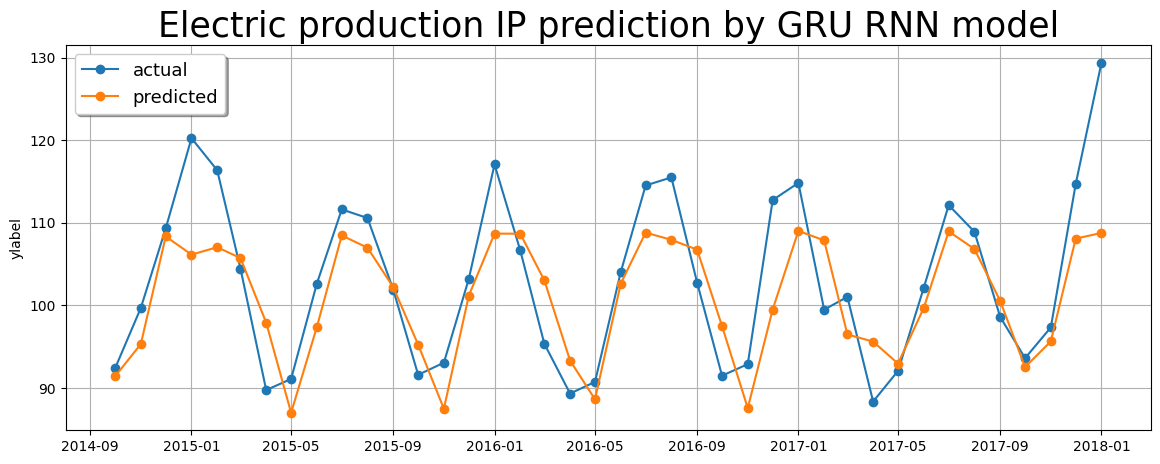

In [25]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by GRU RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 6 LSTM

---
### 6.1 Define single RNN cell

In [75]:
class LSTMCell(torch.nn.Module):
    """
    A simple LSTM cell network for educational AI-summer purposes
    """
    def __init__(self, input_length=10, hidden_size=20, bias=True):
        super(LSTMCell, self).__init__()
        self.input_length = input_length
        self.hidden_size = hidden_size
        self.bias = bias

        """Define Needed Layers """
        self.forget_gate_Wxh = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.forget_gate_Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.input_gate_Wxh = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.input_gate_Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.output_gate_Wxh = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.output_gate_Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.cell_memory_gate_Wxh = nn.Parameter(torch.Tensor(hidden_size, input_length))
        self.cell_memory_gate_Whh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        bias_params = [nn.Parameter(torch.Tensor(hidden_size)) if self.bias else 0 for _ in range(4)]
        self.bf, self.bi, self.bc, self.bo = bias_params
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forget(self, x, h):

        fg = torch.sigmoid(x.matmul(self.forget_gate_Wxh.T) + h.matmul(self.forget_gate_Whh.T) + self.bf)

        return fg


    def input_gate(self, x, h):
        ig = torch.sigmoid(x.matmul(self.input_gate_Wxh.T) + h.matmul(self.input_gate_Whh.T) + self.bi)
        return ig


    def cell_memory_gate(self, i, f, x, h, c_prev):
        gates = x.matmul(self.cell_memory_gate_Wxh.T) + h.matmul(self.cell_memory_gate_Whh.T) + self.bc
        cell = torch.tanh(gates)
        c_next = i * cell + f * c_prev
        return c_next


    def output_gate(self, x, h):
        gates = x.matmul(self.output_gate_Wxh.T) + h.matmul(self.output_gate_Whh.T) + self.bo
        og = torch.sigmoid(gates)
        return og


    def forward(self, x, hx=None):
        """Define Forward pass"""
        if hx is None:
            hx = (torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device),
                  torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device))

        h_prev, c_prev = hx

        fg = self.forget(x, h_prev)
        ig = self.input_gate(x, h_prev)
        og = self.output_gate(x, h_prev)

        c_next = self.cell_memory_gate(ig, fg, x, h_prev, c_prev)

        h_next = og * torch.tanh(c_next)

        return h_next, c_next


---
### 6.2 LSTM model

In [71]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()
        """Define Needed Layers"""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        self.lstm_cells = nn.ModuleList([LSTMCell(input_size if i == 0 else hidden_size, hidden_size, bias) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, input, hx=None):
        """Define Forward pass"""

        batch_size, seq_len, _ = input.size()

        if hx is None:
            hx = [(torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device),
                   torch.zeros(batch_size, self.hidden_size, dtype=input.dtype, device=input.device))
                  for i in range(self.num_layers)]

        h_t, c_t = list(zip(*hx))
        h_t = list(h_t)
        c_t = list(c_t)

        output = []
        for t in range(seq_len):
            next_input = input[:,t]
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.lstm_cells[layer](next_input, (h_t[layer], c_t[layer]))
                next_input = h_t[layer]
            output.append(h_t[-1])
        h_t = tuple(h_t)
        c_t = tuple(c_t)
        output = torch.stack(output)
        output = self.fc(output[-1])
        return output


---
### 6.3 Train LSTM model and plot losses

In [76]:
LSTM_model = LSTM(input_size=1, hidden_size=50, num_layers=1, bias=True, output_size=1)
LSTM_model.to(device)

LSTM(
  (lstm_cells): ModuleList(
    (0): LSTMCell()
  )
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [77]:
learning_rate = 0.008
n_epochs = 2000
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = learning_rate)

In [78]:
LSTM_best_model, train_losses, val_losses = trainer(LSTM_model, X_train, y_train, X_val, y_val, optimizer, criterion, n_epochs)

Streaming output truncated to the last 5000 lines.
Epoch 150: Validation loss decreased (3509.686035 --> 3479.413330).
	 Train_Loss: 2078.7849 Val_Loss: 3479.4133  BEST VAL Loss: 3479.4133

Epoch 151: Validation loss decreased (3479.413330 --> 3449.429688).
	 Train_Loss: 2055.9531 Val_Loss: 3449.4297  BEST VAL Loss: 3449.4297

Epoch 152: Validation loss decreased (3449.429688 --> 3419.731201).
	 Train_Loss: 2033.3728 Val_Loss: 3419.7312  BEST VAL Loss: 3419.7312

Epoch 153: Validation loss decreased (3419.731201 --> 3390.316895).
	 Train_Loss: 2011.0402 Val_Loss: 3390.3169  BEST VAL Loss: 3390.3169

Epoch 154: Validation loss decreased (3390.316895 --> 3361.180908).
	 Train_Loss: 1988.9525 Val_Loss: 3361.1809  BEST VAL Loss: 3361.1809

Epoch 155: Validation loss decreased (3361.180908 --> 3332.322266).
	 Train_Loss: 1967.1072 Val_Loss: 3332.3223  BEST VAL Loss: 3332.3223

Epoch 156: Validation loss decreased (3332.322266 --> 3303.734863).
	 Train_Loss: 1945.5011 Val_Loss: 3303.7349  BE

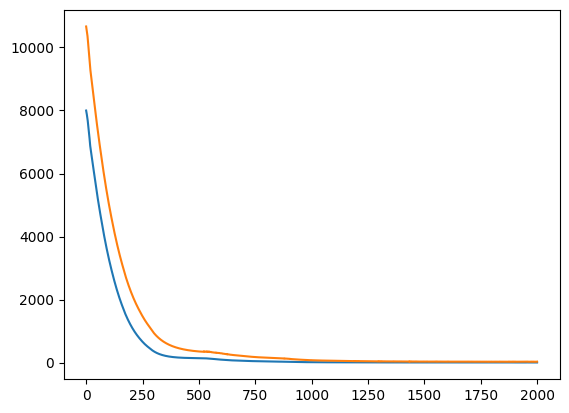

In [31]:
plt.plot(train_losses, label = 'Train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.show()

---
### 6.4 Evaluate model on validation data

In [32]:
val_predict_LSTM = LSTM_best_model(X_val)

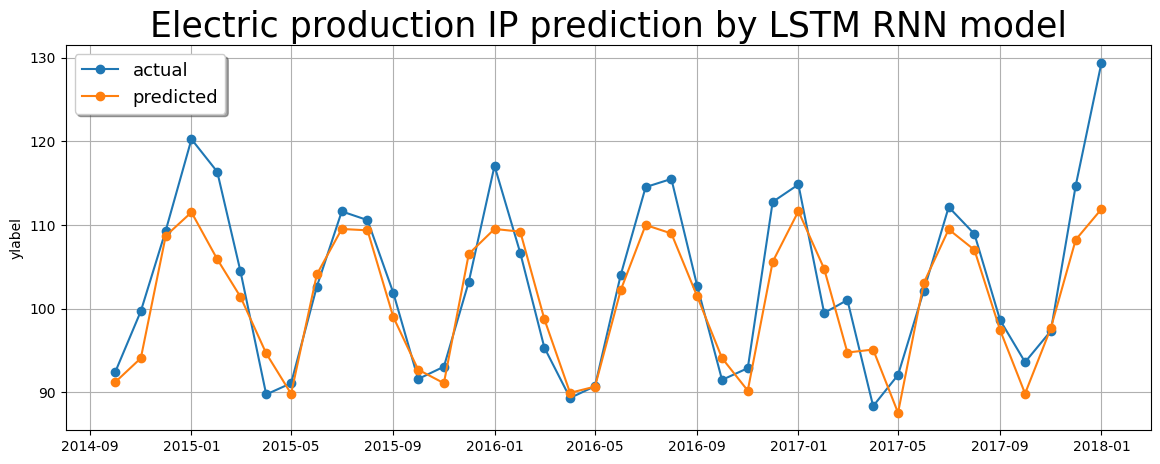

In [33]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN model", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()

---
---
## 7 Comaprison

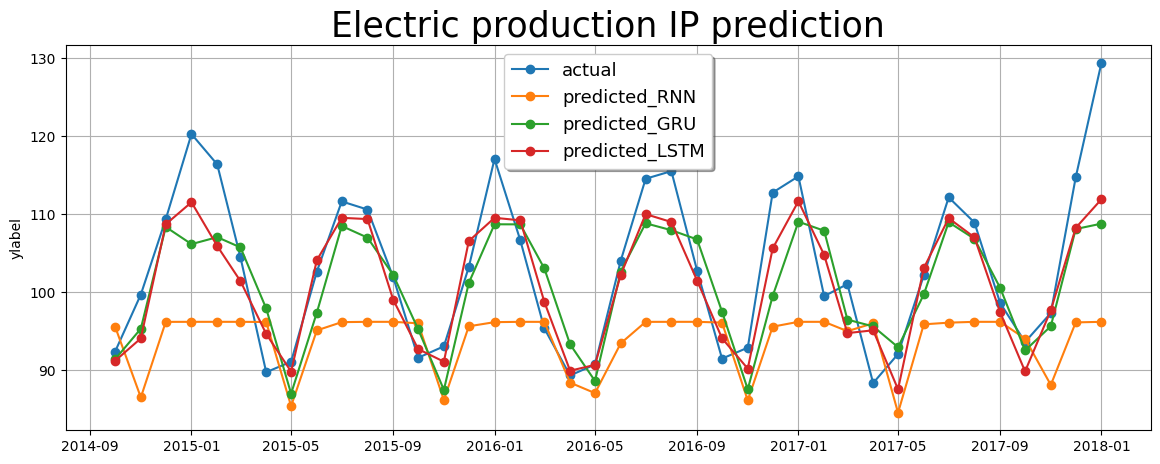

In [34]:
plt.figure(figsize=(14,5))
plt.plot(df[-len(y_val):].index, y_val.cpu(), label="actual", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_RNN.detach().cpu(), label="predicted_RNN", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_GRU.detach().cpu(), label="predicted_GRU", marker="o")
plt.plot(df[-len(y_val):].index, val_predict_LSTM.detach().cpu(), label="predicted_LSTM", marker="o")
plt.title("Electric production IP prediction", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.grid()
plt.show()


<b>1-Rank these architectures based on their performance?

2-Why are they ranked in this order?

3-Run the notebook again with look_back = 15.
write about the difference in the comparison plot and the possible cause for that difference.</b>

<font color='#73FF73'><b>Your answer:</b></font>


**Q1** :1-LSTM  ... 2-GRU ...  3_RNN

**Q2**: Because while RNNs are simpler and can be used effectively on short sequences, they struggle with longer sequences due to the vanishing gradient problem. LSTMs and GRUs, on the other hand, are designed to combat this issue and work well on longer sequences, with LSTMs being more complex and GRUs providing a simpler and faster alternative.

**Q3**: If we reduce the dependancy of prediction on past datas the RNN perform better thatn before because its problem about forgeting the long sequences and vanishing gradients become much better.